# Assignment 3 - expedia-hotel-recommendations


Planning your dream vacation, or even a weekend escape, can be an overwhelming affair. With hundreds, even thousands, of hotels to choose from at every destination, it's difficult to know which will suit your personal preferences. Should you go with an old standby with those pillow mints you like, or risk a new hotel with a trendy pool bar? 

Expedia wants to take the proverbial rabbit hole out of hotel search by providing personalized hotel recommendations to their users. This is no small task for a site with hundreds of millions of visitors every month!

Currently, Expedia uses search parameters to adjust their hotel recommendations, but there aren't enough customer specific data to personalize them for each user. In this competition, Expedia is challenging Kagglers to contextualize customer data and predict the likelihood a user will stay at 100 different hotel groups.

The data in this competition is a random selection from Expedia and is not representative of the overall statistics. 

https://www.kaggle.com/c/expedia-hotel-recommendations

** Note **

Assumptions (As data provided is subset):

 - only hotel_cluster in train data are considered as valid cluster. There are 2 clusters, 87 and 31 which doesn't occur in train.
 - We didn't concentrate on output accuray as subset data provided is very less

In [165]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [178]:
# load data

train_data = pd.read_csv("data/train.csv",index_col=0)
destinationfeatures = pd.read_csv("data/destinations.csv")
test_data = pd.read_csv("data/test.csv",index_col=0)
test_label = pd.read_csv("data/testlabels.csv",index_col=0)

In [179]:
train_data.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
1,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
2,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
3,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
4,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
5,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [180]:
destinationfeatures.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [238]:
# handle na
train_data = train_data.fillna('-1')

In [210]:
# covert all values > zeros
train_features = destinationfeatures.iloc[:,1:] + 3

In [211]:
train_features = train_features.as_matrix()

### Pre process data


** columns dropped: Reason **

- date_time : date column 
- srch_ci : date column
- srch_co : data column

Note: Date columns can be considered by infering more info like month, week, day etc which are meaningful to train model

In [226]:
# columns to consider

x_columns = ['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_type_id',
       'hotel_continent', 'hotel_country', 'hotel_market','srch_destination_id']


y_columns = ['hotel_cluster']


In [300]:
train_x,train_y = train_data[x_columns],train_data[y_columns]

In [301]:
test_x, test_y = test_data[x_columns],test_label[y_columns]

### Perfrom auto encoding

Observation:

 - epoch 10 is choosen based convergence

In [194]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

In [230]:
# size of our encoded representations
encoding_dim = 32

# input placeholder
input_features = Input(shape=(149,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_features)


# "decoded" is the lossy reconstruction of the input
decoded = Dense(149, activation='relu')(encoded)




# this model maps an input to its reconstruction
autoencoder = Model(input_features, decoded)

encoder = Model(input_features, encoded)

adadelta = optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0005)


autoencoder.compile(optimizer=adadelta, loss='mean_squared_error')

In [200]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 149)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 32)                4800      
_________________________________________________________________
dense_75 (Dense)             (None, 149)               4917      
Total params: 9,717
Trainable params: 9,717
Non-trainable params: 0
_________________________________________________________________


In [201]:
history = autoencoder.fit(train_features,train_features,epochs=10,batch_size=32,shuffle=True,validation_split=0.1)

/opt/conda/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 55895 samples, validate on 6211 samples
Epoch 1/10
55895/55895 [==============================] - 3s - loss: 0.2004 - val_loss: 0.1817
Epoch 2/10
55895/55895 [==============================] - 3s - loss: 0.1797 - val_loss: 0.1771
Epoch 3/10
55895/55895 [==============================] - 3s - loss: 0.1767 - val_loss: 0.1769
Epoch 4/10
55895/55895 [==============================] - 3s - loss: 0.1750 - val_loss: 0.1726
Epoch 5/10
55895/55895 [==============================] - 3s - loss: 0.1722 - val_loss: 0.1725
Epoch 6/10
55895/55895 [==============================] - 3s - loss: 0.1722 - val_loss: 0.1725
Epoch 7/10
55895/55895 [==============================] - 3s - loss: 0.1722 - val_loss: 0.1725
Epoch 8/10
55895/55895 [==============================] - 3s - loss: 0.1721 - val_loss: 0.1725
Epoch 9/10
55895/55895 [==============================] - 3s - loss: 0.1721 - val_loss: 0.1724
Epoch 10/10
55895/55895 [==============================] - 3s - loss: 0.1721 - val_loss: 0.1724


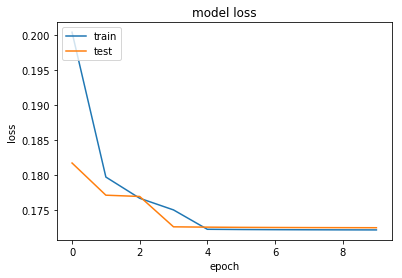

In [202]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Replace 'srch_destination_id' with trained reduced destination features 

In [236]:
encoded_values = encoder.predict(train_features)

In [249]:
encoded_values = np.concatenate((destinationfeatures.iloc[:,:1].as_matrix(),encoded_values), axis = 1)

In [251]:
encoded_values = pd.DataFrame(encoded_values)

In [261]:
encoded_values.columns = ['srch_destination_id'] + list(range(32))

** Replace srch_destination_id with 32 dim. If srch_destination_id is not present, replace with array of [0]**

In [302]:
new_train_x = []

for i,row in train_x.iterrows():
    temp1 = row.as_matrix()
    try:
        temp2 = encoded_values[encoded_values['srch_destination_id'] == row['srch_destination_id']].as_matrix().reshape(33)
    except:
        temp2 = [0] * 33
    new_train_x.append(np.concatenate((temp1[:17],temp2[1:]),axis = 0))
        
new_train_x = np.array(new_train_x)

new_train_x.shape

(1000, 49)

In [303]:
new_test_x = []

for i,row in test_x.iterrows():
    temp1 = row.as_matrix()
    try:
        temp2 = encoded_values[encoded_values['srch_destination_id'] == row['srch_destination_id']].as_matrix().reshape(33)
    except:
        temp2 = [0] * 33
    new_test_x.append(np.concatenate((temp1[:17],temp2[1:]),axis = 0))
        
new_test_x = np.array(new_test_x)

new_test_x.shape

(500, 49)

In [312]:
def cast_column(data):
    
    #column_data = np.array(column_data)
    clusters = np.unique(train_y)
    
    
    casted_data = pd.DataFrame()
    
    for cluster in clusters:
        temp = []
        for i in data:
            if i == cluster:
                temp.append(1)
            else:
                temp.append(0)
            
        casted_data["cluster_" + str(cluster)] = temp
    
    return casted_data

In [349]:
unique_clusters = len(np.unique(train_y))

unique_clusters_number = np.unique(train_y)

new_train_y = cast_column(train_y).as_matrix()
new_test_y = cast_column(test_y).as_matrix()

# Build neural network model

In [342]:
#import keras packages 

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [372]:
#Build keras model
model = Sequential()
model.add(Dense(units=60, input_dim=49,kernel_initializer='random_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(units=40,kernel_initializer='random_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(units=unique_clusters))
model.add(Activation('softmax'))

In [373]:
model.compile(loss='binary_crossentropy',
              optimizer='adam')

In [374]:
history = model.fit(new_train_x,new_train_y,epochs=10, batch_size=16,verbose = 2,shuffle = True,validation_split=0.1)

/opt/conda/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 900 samples, validate on 100 samples
Epoch 1/10
0s - loss: 0.2410 - val_loss: 0.2117
Epoch 2/10
0s - loss: 0.1614 - val_loss: 0.0584
Epoch 3/10
0s - loss: 0.0610 - val_loss: 0.0583
Epoch 4/10
0s - loss: 0.0586 - val_loss: 0.0582
Epoch 5/10
0s - loss: 0.0586 - val_loss: 0.0582
Epoch 6/10
0s - loss: 0.0579 - val_loss: 0.0581
Epoch 7/10
0s - loss: 0.0577 - val_loss: 0.0581
Epoch 8/10
0s - loss: 0.0575 - val_loss: 0.0580
Epoch 9/10
0s - loss: 0.0574 - val_loss: 0.0580
Epoch 10/10
0s - loss: 0.0573 - val_loss: 0.0579


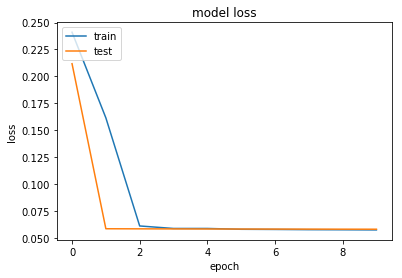

In [375]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [376]:
predicted = model.predict(new_test_x)

/opt/conda/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


In [377]:
top_5_clusters = []

for arr in predicted:
    print(arr.argsort()[-5:][::-1])

[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 38 94]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 38]
[ 8 33 90 94 3